# Calculation Part


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap


In [2]:
def load_images(folder):
    images = []
    labels = []
    class_dirs = ['Carambula', 'Lychee', 'Pear']
    for idx, fruit in enumerate(class_dirs):
        fruit_path = os.path.join(folder, fruit)
        for image_name in os.listdir(fruit_path):
            image_path = os.path.join(fruit_path, image_name)
            img = Image.open(image_path).convert('L')
            img = np.array(img).flatten()
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)


def preprocess_data(data_folder, pca_components):
    X_train, y_train = load_images(os.path.join(data_folder, 'Data_train'))
    X_test, y_test = load_images(os.path.join(data_folder, 'Data_test'))

    # Normalize the data
    X_train = X_train / 255
    X_test = X_test / 255

    # Perform PCA
    pca = PCA(n_components=pca_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Add bias term
    X_train_pca = np.hstack((X_train_pca, np.ones((X_train_pca.shape[0], 1))))
    X_test_pca = np.hstack((X_test_pca, np.ones((X_test_pca.shape[0], 1))))

    return X_train_pca, X_test_pca, y_train, y_test


def one_hot_encode(y, num_classes):
    y_one_hot = np.zeros((len(y), num_classes))
    unique_labels = np.unique(y)
    for i, label in enumerate(unique_labels):
        y_one_hot[y == label, i] = 1
    return y_one_hot


def sigmoid(x):
    x = np.clip(x, -500, 500)  # Limit the input values to avoid overflow
    return 1 / (1 + np.exp(-x))


def sigmoid_derivative(x):
    return x * (1 - x)


class TwoLayerNN:
    def __init__(self, input_nodes, hidden_nodes, output_nodes):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.loss_arr = []

        self.weights1 = np.random.randn(self.input_nodes, self.hidden_nodes)
        self.weights2 = np.random.randn(self.hidden_nodes, self.output_nodes)
        self.bias1 = np.random.randn(1, self.hidden_nodes)
        self.bias2 = np.random.randn(1, self.output_nodes)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.layer1 = sigmoid(np.dot(X, self.weights1) + self.bias1)
        output = self.softmax(np.dot(self.layer1, self.weights2) + self.bias2)
        return output

    def backprop(self, X, y, output, learning_rate=0.001):
        self.layer2_error = y - output
        self.layer2_delta = self.layer2_error * sigmoid_derivative(output)

        self.layer1_error = np.dot(self.layer2_delta, self.weights2.T)
        self.layer1_delta = self.layer1_error * sigmoid_derivative(self.layer1)

        self.weights1 += learning_rate * np.dot(X.T, self.layer1_delta)
        self.weights2 += learning_rate * \
            np.dot(self.layer1.T, self.layer2_delta)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = len(y_true)
        y_pred_clipped = np.clip(y_pred, 1e-12, 1 - 1e-12)
        loss = -np.sum(y_true * np.log(y_pred_clipped)) / n_samples
        return loss

    def train(self, X, y, epochs=1000, learning_rate=0.001, batch_size=16):
        for epoch in range(epochs):
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            for start_idx in range(0, len(X), batch_size):
                batch_indices = indices[start_idx:start_idx + batch_size]
                X_batch, y_batch = X[batch_indices], y[batch_indices]

                output_batch = self.forward(X_batch)

                self.backprop(X_batch, y_batch, output_batch, learning_rate)

            loss = self.cross_entropy_loss(y_batch, output_batch)
            self.loss_arr.append(loss)
            if epoch % 100 == 0:
                print(f'loss: {loss}')

    def predict(self, X):
        output = self.forward(X)
        predictions = np.argmax(output, axis=1)
        return predictions

    def plot_loss(self):
        plt.plot(self.loss_arr, 'r-', label='training loss')
        plt.xlabel('Epoch(s)')
        plt.ylabel('Cross-entropy loss')
        plt.legend()
        plt.show()

    def plot_decision_regions(self, X, y, label):
        # Create a grid of points
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                             np.arange(y_min, y_max, 0.1))

        # Flatten the grid points and add a column of ones for the bias term
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_points = np.hstack(
            (grid_points, np.ones((grid_points.shape[0], 1))))

        # Pass the grid points through the neural network
        output = self.forward(grid_points)
        predictions = np.argmax(output, axis=1)

        # Reshape the predictions to match the grid shape
        predictions = predictions.reshape(xx.shape)

        # Plot the decision regions
        plt.contourf(xx, yy, predictions, alpha=0.3)
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=80)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.title(label)
        plt.show()


def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)

    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)

    split_index = int(data_size * (1 - test_size))
    train_indices = indices[:split_index]
    test_indices = indices[split_index:]

    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


def accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    return correct / len(y_true)


In [3]:
# Load and preprocess your dataset (PCA and train-validation split)
data_folder = 'Data'
pca_components = 2

X_train, X_test, y_train, y_test = preprocess_data(data_folder, pca_components)
X_train, X_val, y_train, y_val = custom_train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

num_classes = 3
y_train_one_hot = one_hot_encode(y_train, num_classes)
y_val_one_hot = one_hot_encode(y_val, num_classes)

# Define neural network parameters
input_nodes = 3  # Two principal components plus bias
hidden_nodes = 256
output_nodes = 3

# Create and train the neural network
nn = TwoLayerNN(input_nodes, hidden_nodes, output_nodes)
nn.train(X_train, y_train_one_hot, epochs=1000, batch_size=16)

# Evaluate the model's performance on the validation data
y_val_pred = nn.predict(X_val)
val_accuracy = accuracy(y_val, y_val_pred)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')


loss: 3.709331165216763
loss: 0.03468814637323517
loss: 0.8167671966455636
loss: 0.560137735821847
loss: 0.06619219475769428
loss: 0.0859912966462238
loss: 0.4396616220278826
loss: 0.24343402095375405
loss: 0.17067793490940555
loss: 0.3588258697345227
Validation accuracy: 94.22%


# Accuracy Part


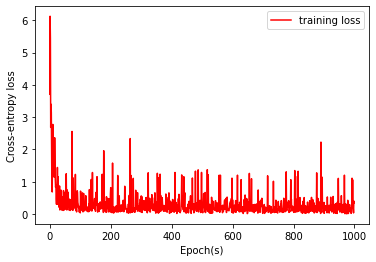

In [4]:
nn.plot_loss()


# Decision Part


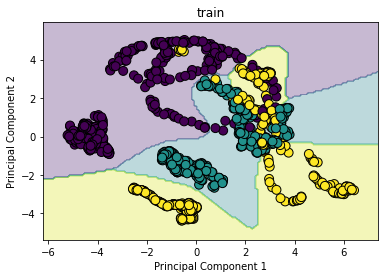

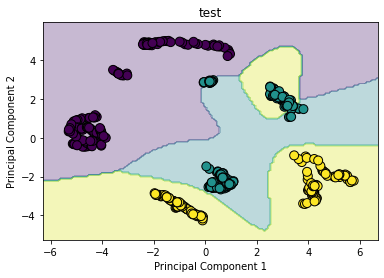

In [5]:
nn.plot_decision_regions(X_train, y_train, label='train')
nn.plot_decision_regions(X_test, y_test, label='test')


# Batch Size


--Train batch_sizes = 8 start--
loss: 2.97077427754592
loss: 0.18628080648690873
loss: 0.04235036440828048
loss: 0.1372376259265983
loss: 0.13874540741612623
--Train batch_sizes = 16 start--
loss: 5.099459976289667
loss: 0.25119771644733013
loss: 0.1356393890073735
loss: 0.5187401419695536
loss: 0.6816395540982001
--Train batch_sizes = 32 start--
loss: 3.847834213989344
loss: 0.152838238517944
loss: 0.22479792007982694
loss: 0.21377290632987286
loss: 0.4542482354901407
--Train batch_sizes = 64 start--
loss: 4.070049181640516
loss: 0.21119841506922624
loss: 0.2752183691185727
loss: 0.262839490658702
loss: 0.4117602216420045


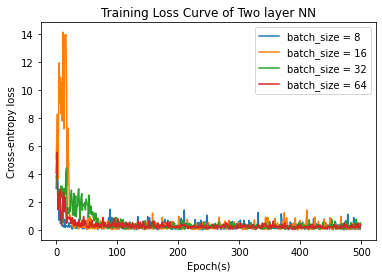

In [8]:
batch_sizes = [2**i for i in range(3, 7)]
for batch_size in batch_sizes:
    print(f'--Train batch_sizes = {batch_size} start--')
    nn = TwoLayerNN(input_nodes=input_nodes,
                    hidden_nodes=hidden_nodes, output_nodes=output_nodes)
    nn.train(X_train, y_train_one_hot, epochs=500, batch_size=batch_size)
    plt.plot(nn.loss_arr, label=f'batch_size = {batch_size}')
plt.title(f'Training Loss Curve of Two layer NN')
plt.xlabel('Epoch(s)')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()


# Hidden Layer Size


--Train hidden_size = 16 start--
loss: 1.7179407917095142
loss: 0.6376568582738692
loss: 0.42843771244698153
loss: 0.32701630969654305
loss: 0.4262849327079679
--Train hidden_size = 32 start--
loss: 2.4285562692073275
loss: 0.32264495597684356
loss: 0.6244759916513863
loss: 0.318304040265271
loss: 0.39635210609169363
--Train hidden_size = 64 start--
loss: 4.302439398360086
loss: 0.19727041386980745
loss: 0.2040867718582362
loss: 0.23618081275446234
loss: 0.603602105526038
--Train hidden_size = 128 start--
loss: 1.9547500784745366
loss: 0.37645113594342217
loss: 0.547126728554982
loss: 0.22077501682773826
loss: 0.3530313045286486


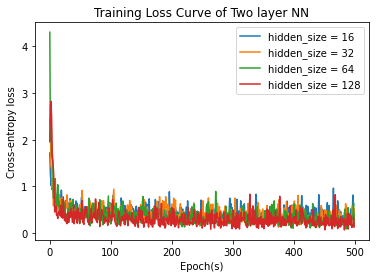

In [7]:
hidden_sizes = [2**i for i in range(4, 8)]
for hidden_size in hidden_sizes:
    print(f'--Train hidden_size = {hidden_size} start--')
    nn = TwoLayerNN(input_nodes=input_nodes,
                    hidden_nodes=hidden_size, output_nodes=output_nodes)
    nn.train(X_train, y_train_one_hot, epochs=500, batch_size=32)
    plt.plot(nn.loss_arr, label=f'hidden_size = {hidden_size}')
plt.title(f'Training Loss Curve of Two layer NN')
plt.xlabel('Epoch(s)')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()
